<a href="https://colab.research.google.com/github/Vedant2100/w26/blob/main/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q1.

In [1]:
from datasets import load_dataset
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

dataset = load_dataset("ylecun/mnist")

def format_data(split, mean=None, std=None):
    images = np.array([np.array(img).flatten() for img in split["image"]])
    if mean is None or std is None:
        mean = np.mean(images, axis=0)
        std = np.std(images, axis=0)
    std_copy = std.copy()
    std_copy[std_copy == 0] = 1.0
    X = (images - mean) / std_copy
    X = np.hstack([X, np.ones((X.shape[0], 1))])
    y = np.array([int(l > 4) for l in split["label"]])
    return X, y, mean, std

README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Q2. Linear Classifier

In [4]:
X_train, y_train, train_mean, train_std = format_data(dataset["train"])
X_test, y_test, _, _ = format_data(dataset["test"], train_mean, train_std)
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of y_train: (60000,)
Shape of y_test: (10000,)


In [5]:
def minibatch_sgd(ITR, B, lr, X_train, y_train, X_test, y_test):
    W = np.random.normal(0, 1/np.sqrt(785), (1, 785))
    loss_hist, acc_hist = [], []
    start = time.time()
    N_tr = len(X_train)
    for t in tqdm(range(ITR)):
        idx = np.random.choice(N_tr, B, replace=True)
        X_b = X_train[idx]
        y_b = y_train[idx].reshape(-1, 1)
        y_p = X_b @ W.T
        grad = (1/B) * (y_p - y_b).T @ X_b
        W -= lr * grad
        loss = 0.5 * np.mean((y_p - y_b)**2)
        loss_hist.append(loss)
        test_scores = X_test @ W.T
        test_preds = (test_scores.flatten() > 0.5).astype(int)
        acc = np.mean(test_preds == y_test)
        acc_hist.append(acc)
    return W, loss_hist, acc_hist, (time.time() - start)

100%|██████████| 50000/50000 [04:58<00:00, 167.47it/s]


lr=0.001: Time=298.57s, Accuracy=0.4060


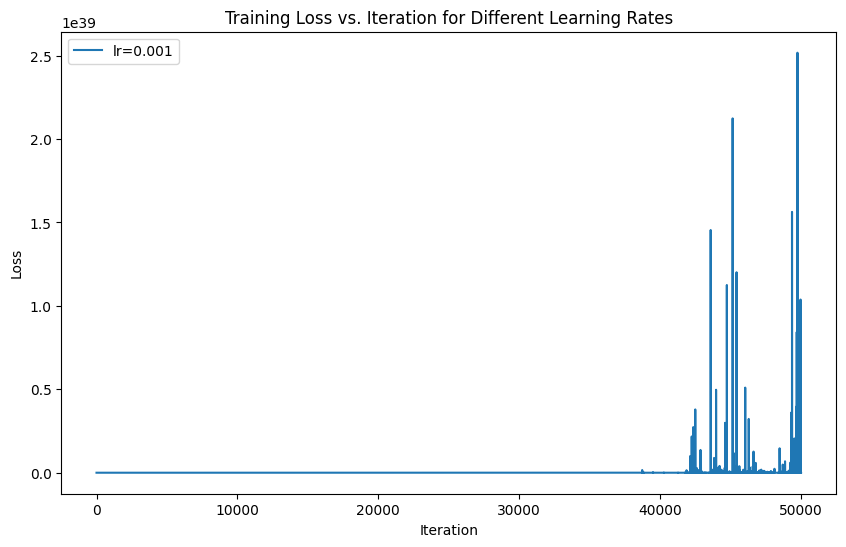

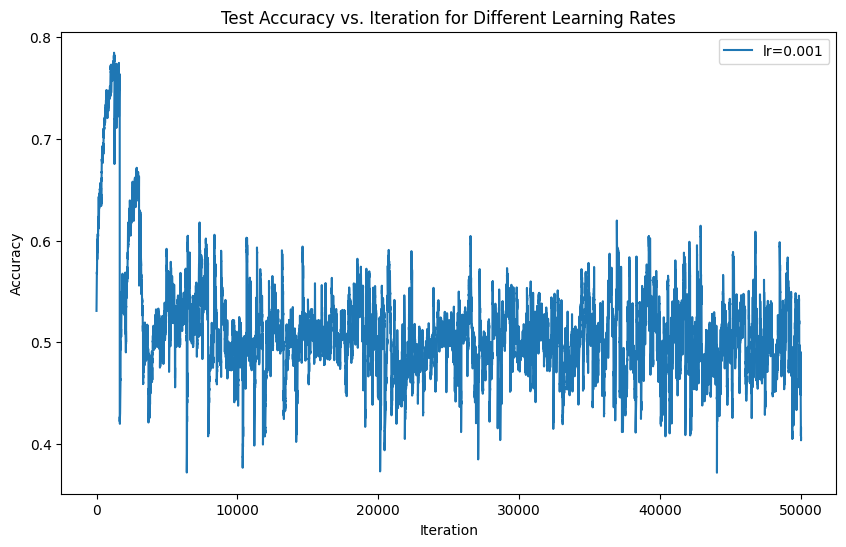

In [6]:
B = 10
lr = 0.001
ITR = 50000

plt.figure(figsize=(10, 6))
plt.title("Training Loss vs. Iteration for Different Learning Rates")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.figure(figsize=(10, 6))
plt.title("Test Accuracy vs. Iteration for Different Learning Rates")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

loss_fig = plt.figure(1)
ax_loss = loss_fig.gca()
acc_fig = plt.figure(2)
ax_acc = acc_fig.gca()


_, losses, accs, dur = minibatch_sgd(ITR, B, lr, X_train, y_train, X_test, y_test)
print(f"lr={lr}: Time={dur:.2f}s, Accuracy={accs[-1]:.4f}")

ax_loss.plot(losses, label=f"lr={lr}")
ax_acc.plot(accs, label=f"lr={lr}")

ax_loss.legend()
ax_acc.legend()

loss_fig.show()
acc_fig.show()

In [ ]:
B = 10
lr = 0.005
ITR = 50000

plt.figure(figsize=(10, 6))
plt.title("Training Loss vs. Iteration for Different Learning Rates")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.figure(figsize=(10, 6))
plt.title("Test Accuracy vs. Iteration for Different Learning Rates")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

loss_fig = plt.figure(1)
ax_loss = loss_fig.gca()
acc_fig = plt.figure(2)
ax_acc = acc_fig.gca()


_, losses, accs, dur = minibatch_sgd(ITR, B, lr, X_train, y_train, X_test, y_test)
print(f"lr={lr}: Time={dur:.2f}s, Accuracy={accs[-1]:.4f}")

ax_loss.plot(losses, label=f"lr={lr}")
ax_acc.plot(accs, label=f"lr={lr}")

ax_loss.legend()
ax_acc.legend()

loss_fig.show()
acc_fig.show()

Test accuracy of the linear classifier is 0.40. Since it involves a linear regression with quadratic loss, which is not suited for classification, hence the accuracy is low, no matter the learning rate.

Q3. Neural Network with. k = 5, 50, 200 hidden units


In [ ]:
def ReLU(x):
    return np.maximum(0, x)

def minibatch_sgd_nn(ITR, B, lr, X_train, y_train, X_test, y_test, k):
    W1 = np.random.normal(0, 1/np.sqrt(785), (k, 785))
    W2 = np.random.normal(0, 1/np.sqrt(k), (1, k))
    loss_hist, acc_hist = [], []
    start = time.time()
    N_tr = len(X_train)
    for t in tqdm(range(ITR)):
        idx = np.random.choice(N_tr, B, replace=True)
        X_b = X_train[idx]
        y_b = y_train[idx].reshape(-1, 1)

        z = X_b @ W1.T
        a = ReLU(z)
        y_p = a @ W2.T

        grad_W2 = (1/B) * (y_p - y_b).T @ a
        grad_a = (1/B) * (y_p - y_b) @ W2
        grad_z = grad_a * (z > 0)
        grad_W1 = (1/B) * grad_z.T @ X_b

        W1 -= lr * grad_W1
        W2 -= lr * grad_W2

        loss = 0.5 * np.mean((y_p - y_b)**2)
        loss_hist.append(loss)

        test_scores_hidden = X_test @ W1.T
        test_scores_activated = ReLU(test_scores_hidden)
        test_scores = test_scores_activated @ W2.T

        test_preds = (test_scores.flatten() > 0.5).astype(int)
        acc = np.mean(test_preds == y_test)
        acc_hist.append(acc)

    return W1, W2, loss_hist, acc_hist, (time.time() - start)

Training Neural Network with k=5 hidden units, B=10, ITR=50000, lr=0.001


100%|██████████| 50000/50000 [02:50<00:00, 292.73it/s]


NN (k=5, lr=0.001): Time=170.81s, Final Test Accuracy=0.8391
Training Neural Network with k=50 hidden units, B=10, ITR=50000, lr=0.001


100%|██████████| 50000/50000 [06:34<00:00, 126.61it/s]


NN (k=50, lr=0.001): Time=394.90s, Final Test Accuracy=0.8753
Training Neural Network with k=200 hidden units, B=10, ITR=50000, lr=0.001


100%|██████████| 50000/50000 [19:36<00:00, 42.49it/s]


NN (k=200, lr=0.001): Time=1176.74s, Final Test Accuracy=0.9002


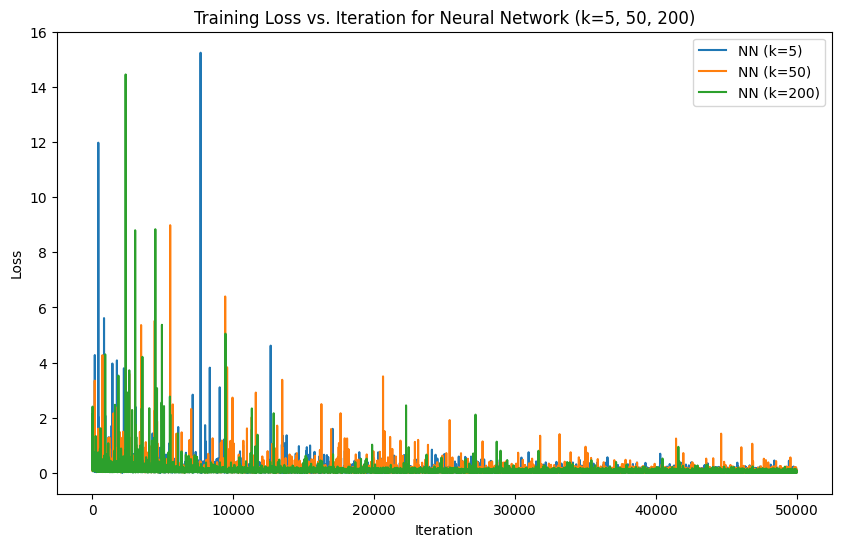

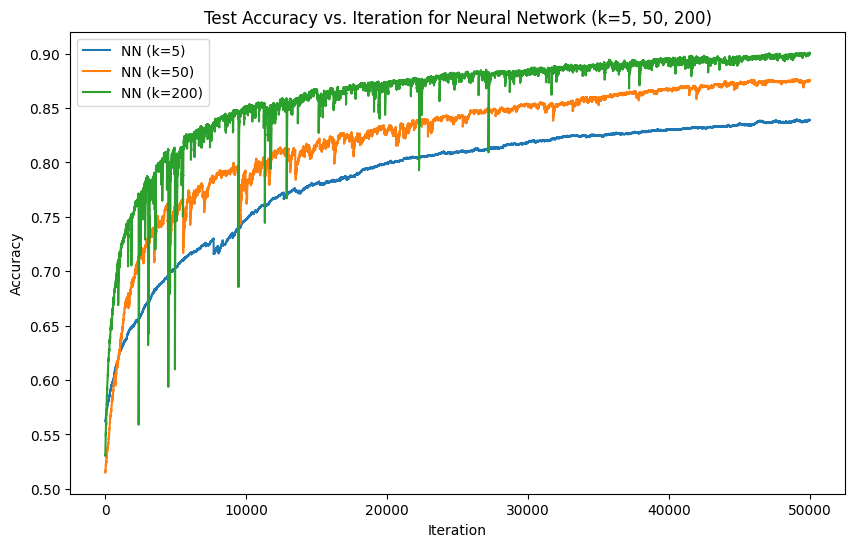

In [ ]:
lr_nn = 0.001
k_values = [5, 50, 200]
results = {}

plt.figure(figsize=(10, 6))
plt.title("Training Loss vs. Iteration for Neural Network (k=5, 50, 200)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
loss_fig = plt.gca()

plt.figure(figsize=(10, 6))
plt.title("Test Accuracy vs. Iteration for Neural Network (k=5, 50, 200)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
acc_fig = plt.gca()

for k in k_values:
  print(f"Training Neural Network with k={k} hidden units, B={B}, ITR={ITR}, lr={lr_nn}")
  W1_nn, W2_nn, losses_nn, accs_nn, dur_nn = minibatch_sgd_nn(ITR, B, lr_nn, X_train, y_train, X_test, y_test, k)
  results[k] = {'losses': losses_nn, 'accs': accs_nn, 'dur': dur_nn}
  print(f"NN (k={k}, lr={lr_nn}): Time={dur_nn:.2f}s, Final Test Accuracy={accs_nn[-1]:.4f}")

  loss_fig.plot(losses_nn, label=f"NN (k={k})")
  acc_fig.plot(accs_nn, label=f"NN (k={k})")

loss_fig.legend()
acc_fig.legend()

plt.show()

Training Neural Network with k=5 hidden units, B=10, ITR=50000, lr=0.0005


100%|██████████| 50000/50000 [02:55<00:00, 284.51it/s]


NN (k=5, lr=0.0005): Time=175.74s, Final Test Accuracy=0.8222
Training Neural Network with k=50 hidden units, B=10, ITR=50000, lr=0.0005


100%|██████████| 50000/50000 [06:32<00:00, 127.30it/s]


NN (k=50, lr=0.0005): Time=392.77s, Final Test Accuracy=0.8518
Training Neural Network with k=200 hidden units, B=10, ITR=50000, lr=0.0005


100%|██████████| 50000/50000 [18:56<00:00, 44.00it/s]


NN (k=200, lr=0.0005): Time=1136.39s, Final Test Accuracy=0.8775


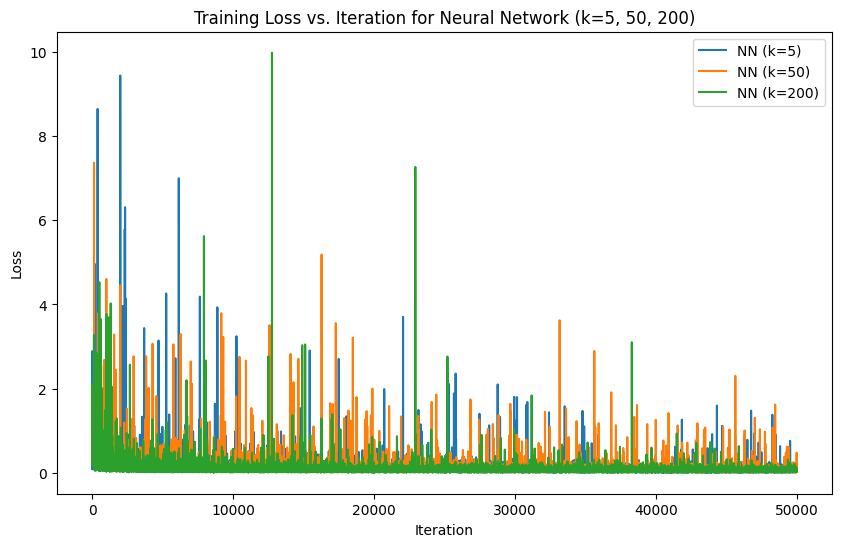

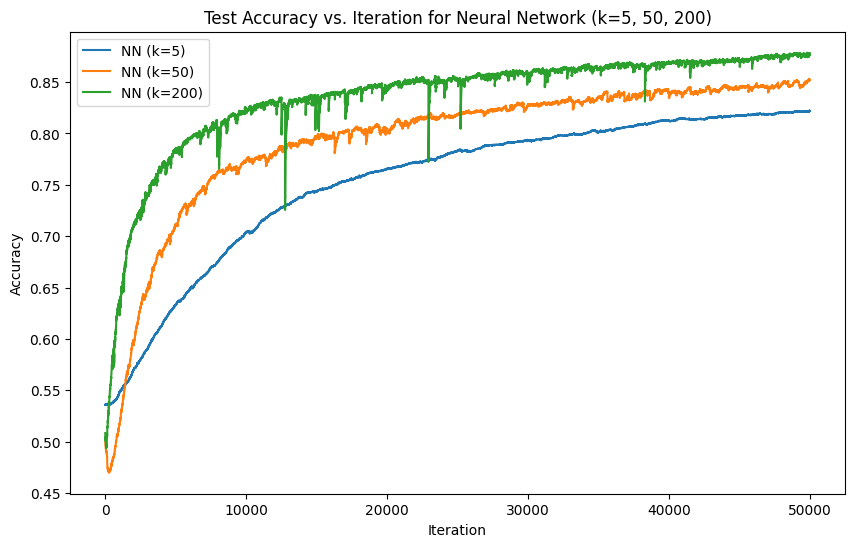

In [ ]:
lr_nn = 0.0005
k_values = [5, 50, 200]
results = {}
B = 10
ITR = 50000

plt.figure(figsize=(10, 6))
plt.title("Training Loss vs. Iteration for Neural Network (k=5, 50, 200)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
loss_fig = plt.gca()

plt.figure(figsize=(10, 6))
plt.title("Test Accuracy vs. Iteration for Neural Network (k=5, 50, 200)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
acc_fig = plt.gca()

for k in k_values:
  print(f"Training Neural Network with k={k} hidden units, B={B}, ITR={ITR}, lr={lr_nn}")
  W1_nn, W2_nn, losses_nn, accs_nn, dur_nn = minibatch_sgd_nn(ITR, B, lr_nn, X_train, y_train, X_test, y_test, k)
  results[k] = {'losses': losses_nn, 'accs': accs_nn, 'dur': dur_nn}
  print(f"NN (k={k}, lr={lr_nn}): Time={dur_nn:.2f}s, Final Test Accuracy={accs_nn[-1]:.4f}")

  loss_fig.plot(losses_nn, label=f"NN (k={k})")
  acc_fig.plot(accs_nn, label=f"NN (k={k})")

loss_fig.legend()
acc_fig.legend()

plt.show()

Training Neural Network with k=5 hidden units, B=10, ITR=50000, lr=0.005


100%|██████████| 50000/50000 [02:57<00:00, 281.30it/s]


NN (k=5, lr=0.005): Time=177.75s, Final Test Accuracy=0.9088
Training Neural Network with k=50 hidden units, B=10, ITR=50000, lr=0.005


100%|██████████| 50000/50000 [06:38<00:00, 125.57it/s]


NN (k=50, lr=0.005): Time=398.20s, Final Test Accuracy=0.9283
Training Neural Network with k=200 hidden units, B=10, ITR=50000, lr=0.005


 27%|██▋       | 13323/50000 [05:10<21:35, 28.31it/s]/tmp/ipython-input-4121352413.py:19: RuntimeWarning: overflow encountered in matmul
  grad_W2 = (1/B) * (y_p - y_b).T @ a
/tmp/ipython-input-4121352413.py:20: RuntimeWarning: overflow encountered in matmul
  grad_a = (1/B) * (y_p - y_b) @ W2
/tmp/ipython-input-4121352413.py:21: RuntimeWarning: invalid value encountered in multiply
  grad_z = grad_a * (z > 0)
/tmp/ipython-input-4121352413.py:22: RuntimeWarning: invalid value encountered in matmul
  grad_W1 = (1/B) * grad_z.T @ X_b
/tmp/ipython-input-4121352413.py:27: RuntimeWarning: overflow encountered in square
  loss = 0.5 * np.mean((y_p - y_b)**2)
/tmp/ipython-input-4121352413.py:15: RuntimeWarning: invalid value encountered in matmul
  z = X_b @ W1.T
100%|██████████| 50000/50000 [19:07<00:00, 43.57it/s]


NN (k=200, lr=0.005): Time=1147.63s, Final Test Accuracy=0.5139


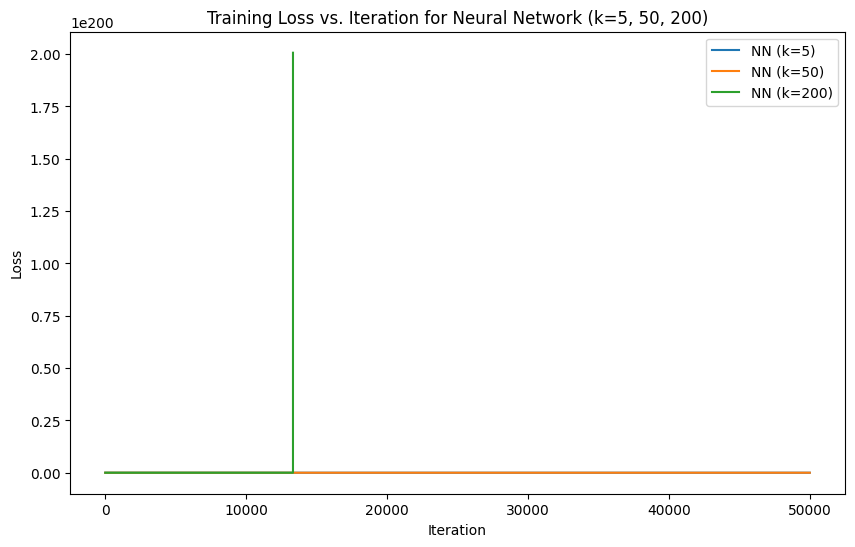

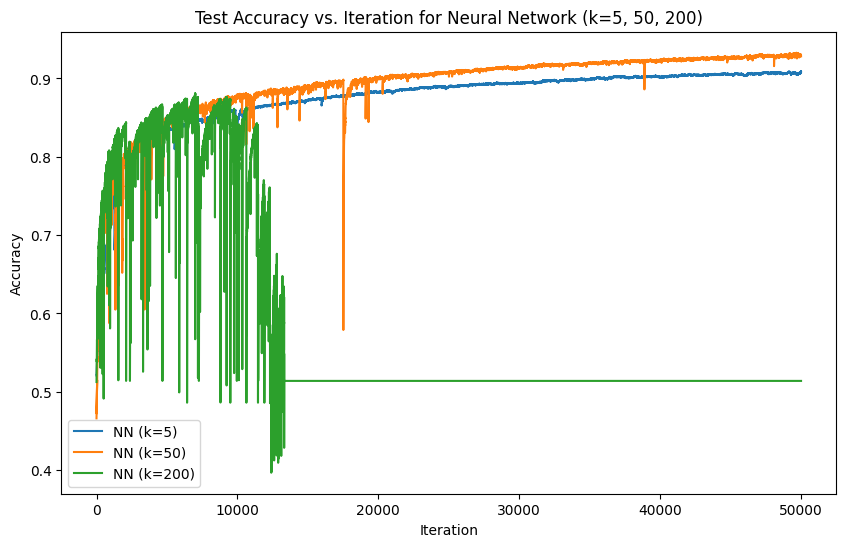

In [ ]:
lr_nn = 0.005
k_values = [5, 50, 200]
results = {}
B = 10
ITR = 50000

plt.figure(figsize=(10, 6))
plt.title("Training Loss vs. Iteration for Neural Network (k=5, 50, 200)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
loss_fig = plt.gca()

plt.figure(figsize=(10, 6))
plt.title("Test Accuracy vs. Iteration for Neural Network (k=5, 50, 200)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
acc_fig = plt.gca()

for k in k_values:
  print(f"Training Neural Network with k={k} hidden units, B={B}, ITR={ITR}, lr={lr_nn}")
  W1_nn, W2_nn, losses_nn, accs_nn, dur_nn = minibatch_sgd_nn(ITR, B, lr_nn, X_train, y_train, X_test, y_test, k)
  results[k] = {'losses': losses_nn, 'accs': accs_nn, 'dur': dur_nn}
  print(f"NN (k={k}, lr={lr_nn}): Time={dur_nn:.2f}s, Final Test Accuracy={accs_nn[-1]:.4f}")

  loss_fig.plot(losses_nn, label=f"NN (k={k})")
  acc_fig.plot(accs_nn, label=f"NN (k={k})")

loss_fig.legend()
acc_fig.legend()

plt.show()

Training Neural Network with k=5 hidden units, B=10, ITR=50000, lr=0.1


  5%|▍         | 2479/50000 [00:07<02:28, 321.04it/s]/tmp/ipython-input-4121352413.py:32: RuntimeWarning: overflow encountered in matmul
  test_scores = test_scores_activated @ W2.T
/tmp/ipython-input-4121352413.py:17: RuntimeWarning: overflow encountered in matmul
  y_p = a @ W2.T
/tmp/ipython-input-4121352413.py:22: RuntimeWarning: invalid value encountered in matmul
  grad_W1 = (1/B) * grad_z.T @ X_b
/tmp/ipython-input-4121352413.py:30: RuntimeWarning: invalid value encountered in matmul
  test_scores_hidden = X_test @ W1.T
100%|██████████| 50000/50000 [02:53<00:00, 287.52it/s]


NN (k=5, lr=0.1): Time=173.90s, Final Test Accuracy=0.5139
Training Neural Network with k=50 hidden units, B=10, ITR=50000, lr=0.1


  0%|          | 136/50000 [00:00<06:08, 135.49it/s]/tmp/ipython-input-4121352413.py:19: RuntimeWarning: overflow encountered in matmul
  grad_W2 = (1/B) * (y_p - y_b).T @ a
/tmp/ipython-input-4121352413.py:20: RuntimeWarning: overflow encountered in matmul
  grad_a = (1/B) * (y_p - y_b) @ W2
/tmp/ipython-input-4121352413.py:27: RuntimeWarning: overflow encountered in square
  loss = 0.5 * np.mean((y_p - y_b)**2)
100%|██████████| 50000/50000 [06:35<00:00, 126.35it/s]


NN (k=50, lr=0.1): Time=395.73s, Final Test Accuracy=0.5139
Training Neural Network with k=200 hidden units, B=10, ITR=50000, lr=0.1


  0%|          | 10/50000 [00:00<17:33, 47.44it/s]/tmp/ipython-input-4121352413.py:21: RuntimeWarning: invalid value encountered in multiply
  grad_z = grad_a * (z > 0)
100%|██████████| 50000/50000 [19:05<00:00, 43.67it/s]


NN (k=200, lr=0.1): Time=1145.03s, Final Test Accuracy=0.5139


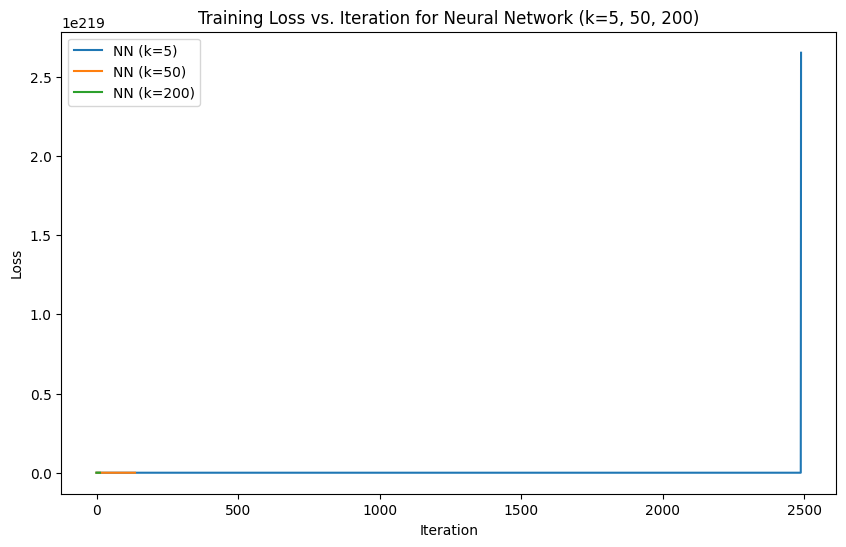

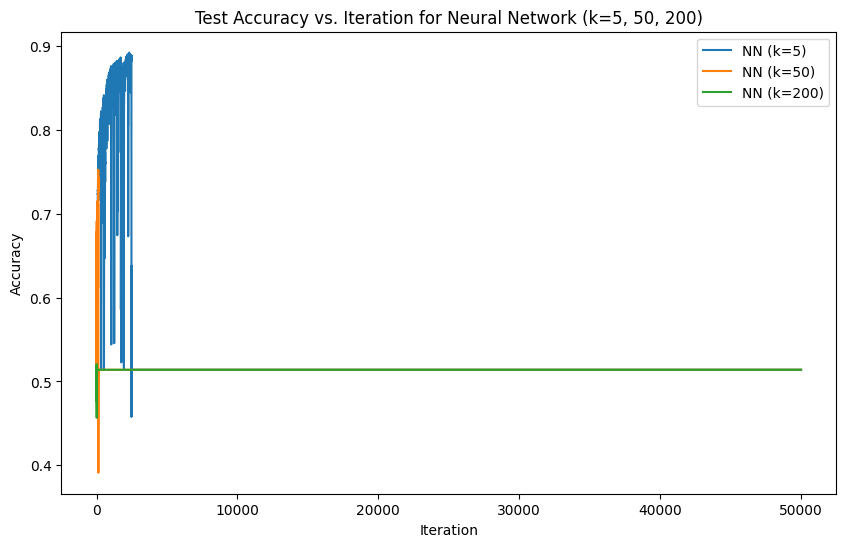

In [ ]:
lr_nn = 0.01
k_values = [5, 50, 200]
results = {}
B = 10
ITR = 50000

plt.figure(figsize=(10, 6))
plt.title("Training Loss vs. Iteration for Neural Network (k=5, 50, 200)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
loss_fig = plt.gca()

plt.figure(figsize=(10, 6))
plt.title("Test Accuracy vs. Iteration for Neural Network (k=5, 50, 200)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
acc_fig = plt.gca()

for k in k_values:
  print(f"Training Neural Network with k={k} hidden units, B={B}, ITR={ITR}, lr={lr_nn}")
  W1_nn, W2_nn, losses_nn, accs_nn, dur_nn = minibatch_sgd_nn(ITR, B, lr_nn, X_train, y_train, X_test, y_test, k)
  results[k] = {'losses': losses_nn, 'accs': accs_nn, 'dur': dur_nn}
  print(f"NN (k={k}, lr={lr_nn}): Time={dur_nn:.2f}s, Final Test Accuracy={accs_nn[-1]:.4f}")

  loss_fig.plot(losses_nn, label=f"NN (k={k})")
  acc_fig.plot(accs_nn, label=f"NN (k={k})")

loss_fig.legend()
acc_fig.legend()

plt.show()

Q4. Logistic Loss

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def minibatch_sgd_nn_logistic(ITR, B, lr, X_train, y_train, X_test, y_test, k):
    W1 = np.random.normal(0, 1/np.sqrt(X_train.shape[1]), (k, X_train.shape[1]))
    W2 = np.random.normal(0, 1/np.sqrt(k), (1, k))
    loss_hist, acc_hist = [], []
    start = time.time()
    N_tr = len(X_train)

    for t in tqdm(range(ITR)):
        idx = np.random.choice(N_tr, B, replace=True)
        X_b = X_train[idx]
        y_b = y_train[idx].reshape(-1, 1)
        z = X_b @ W1.T
        a = ReLU(z)
        logits = a @ W2.T
        probs = sigmoid(logits)
        delta = probs - y_b
        grad_W2 = (1/B) * delta.T @ a
        grad_a = (1/B) * delta @ W2
        grad_z = grad_a * (z > 0)
        grad_W1 = (1/B) * grad_z.T @ X_b

        W1 -= lr * grad_W1
        W2 -= lr * grad_W2
        eps = 1e-8
        loss = -np.mean(y_b * np.log(probs+eps) + (1 - y_b) * np.log(1 - probs+eps))
        loss_hist.append(loss)
        test_hidden = X_test @ W1.T
        test_act = ReLU(test_hidden)
        test_logits = test_act @ W2.T
        test_probs = sigmoid(test_logits)

        test_preds = (test_probs.flatten() > 0.5).astype(int)
        acc = np.mean(test_preds == y_test)
        acc_hist.append(acc)

    return W1, W2, loss_hist, acc_hist, (time.time() - start)


Training Neural Network with k=5 hidden units, B=10, ITR=50000, lr=0.001


100%|██████████| 50000/50000 [03:02<00:00, 274.15it/s]


NN (k=5, lr=0.001): Time=182.38s, Final Test Accuracy=0.9060
Training Neural Network with k=50 hidden units, B=10, ITR=50000, lr=0.001


100%|██████████| 50000/50000 [06:38<00:00, 125.40it/s]


NN (k=50, lr=0.001): Time=398.73s, Final Test Accuracy=0.9229
Training Neural Network with k=200 hidden units, B=10, ITR=50000, lr=0.001


100%|██████████| 50000/50000 [19:09<00:00, 43.49it/s]


NN (k=200, lr=0.001): Time=1149.58s, Final Test Accuracy=0.9308


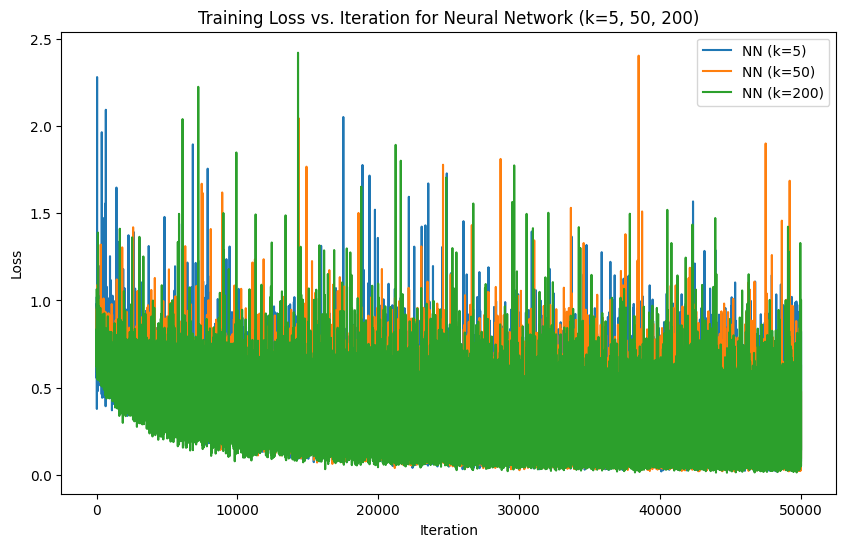

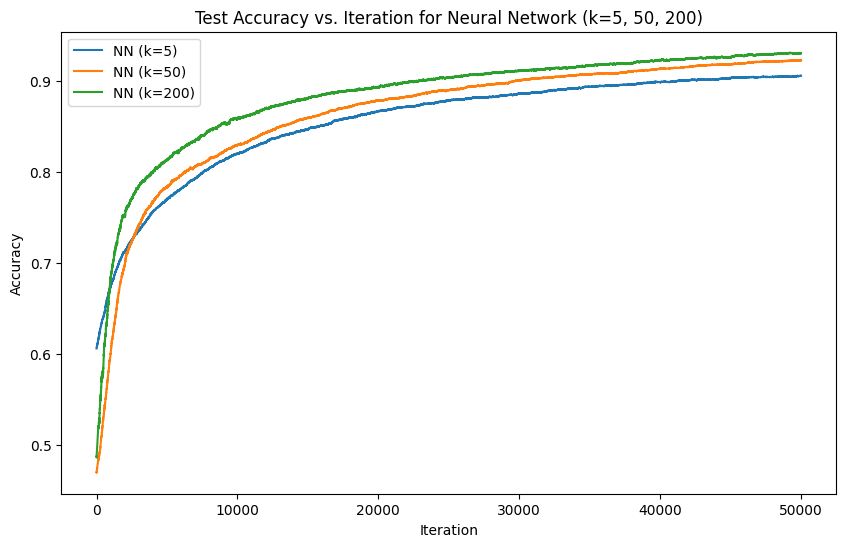

In [ ]:
lr_nn = 0.001
k_values = [5, 50, 200]
results = {}
B = 10
ITR = 50000

plt.figure(figsize=(10, 6))
plt.title("Training Loss vs. Iteration for Neural Network (k=5, 50, 200)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
loss_fig = plt.gca()

plt.figure(figsize=(10, 6))
plt.title("Test Accuracy vs. Iteration for Neural Network (k=5, 50, 200)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
acc_fig = plt.gca()

for k in k_values:
  print(f"Training Neural Network with k={k} hidden units, B={B}, ITR={ITR}, lr={lr_nn}")
  W1_nn, W2_nn, losses_nn, accs_nn, dur_nn = minibatch_sgd_nn_logistic(ITR, B, lr_nn, X_train, y_train, X_test, y_test, k)
  results[k] = {'losses': losses_nn, 'accs': accs_nn, 'dur': dur_nn}
  print(f"NN (k={k}, lr={lr_nn}): Time={dur_nn:.2f}s, Final Test Accuracy={accs_nn[-1]:.4f}")

  loss_fig.plot(losses_nn, label=f"NN (k={k})")
  acc_fig.plot(accs_nn, label=f"NN (k={k})")

loss_fig.legend()
acc_fig.legend()

plt.show()

Training Neural Network with k=5 hidden units, B=10, ITR=50000, lr=0.0005


100%|██████████| 50000/50000 [03:00<00:00, 276.79it/s]


NN (k=5, lr=0.0005): Time=180.65s, Final Test Accuracy=0.8641
Training Neural Network with k=50 hidden units, B=10, ITR=50000, lr=0.0005


100%|██████████| 50000/50000 [06:42<00:00, 124.18it/s]


NN (k=50, lr=0.0005): Time=402.66s, Final Test Accuracy=0.9001
Training Neural Network with k=200 hidden units, B=10, ITR=50000, lr=0.0005


100%|██████████| 50000/50000 [19:12<00:00, 43.37it/s]


NN (k=200, lr=0.0005): Time=1152.82s, Final Test Accuracy=0.8996


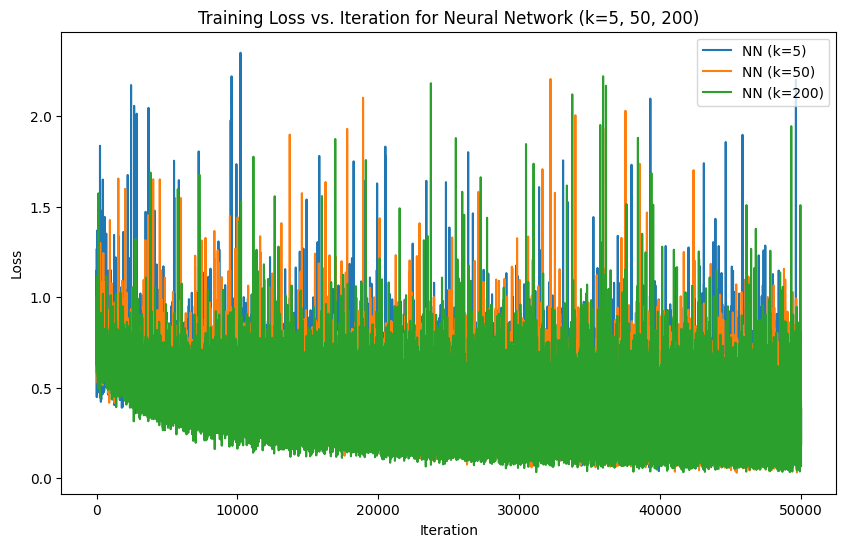

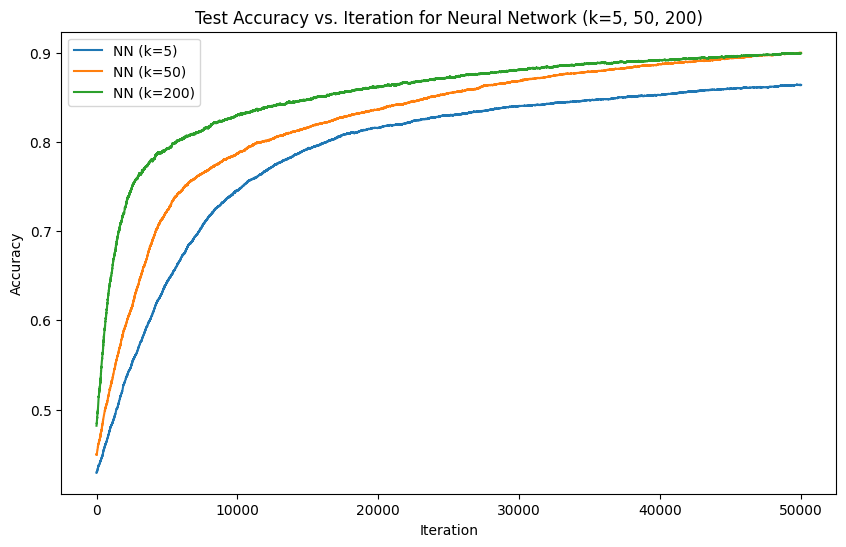

In [ ]:
lr_nn = 0.0005
k_values = [5, 50, 200]
results = {}

plt.figure(figsize=(10, 6))
plt.title("Training Loss vs. Iteration for Neural Network (k=5, 50, 200)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
loss_fig = plt.gca()

plt.figure(figsize=(10, 6))
plt.title("Test Accuracy vs. Iteration for Neural Network (k=5, 50, 200)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
acc_fig = plt.gca()

for k in k_values:
  print(f"Training Neural Network with k={k} hidden units, B={B}, ITR={ITR}, lr={lr_nn}")
  W1_nn, W2_nn, losses_nn, accs_nn, dur_nn = minibatch_sgd_nn_logistic(ITR, B, lr_nn, X_train, y_train, X_test, y_test, k)
  results[k] = {'losses': losses_nn, 'accs': accs_nn, 'dur': dur_nn}
  print(f"NN (k={k}, lr={lr_nn}): Time={dur_nn:.2f}s, Final Test Accuracy={accs_nn[-1]:.4f}")

  loss_fig.plot(losses_nn, label=f"NN (k={k})")
  acc_fig.plot(accs_nn, label=f"NN (k={k})")

loss_fig.legend()
acc_fig.legend()

plt.show()

Training Neural Network with k=5 hidden units, B=10, ITR=50000, lr=0.01


100%|██████████| 50000/50000 [03:01<00:00, 276.20it/s]


NN (k=5, lr=0.01): Time=181.03s, Final Test Accuracy=0.9439
Training Neural Network with k=50 hidden units, B=10, ITR=50000, lr=0.01


100%|██████████| 50000/50000 [06:44<00:00, 123.61it/s]


NN (k=50, lr=0.01): Time=404.51s, Final Test Accuracy=0.9712
Training Neural Network with k=200 hidden units, B=10, ITR=50000, lr=0.01


100%|██████████| 50000/50000 [19:09<00:00, 43.49it/s]


NN (k=200, lr=0.01): Time=1149.79s, Final Test Accuracy=0.9707


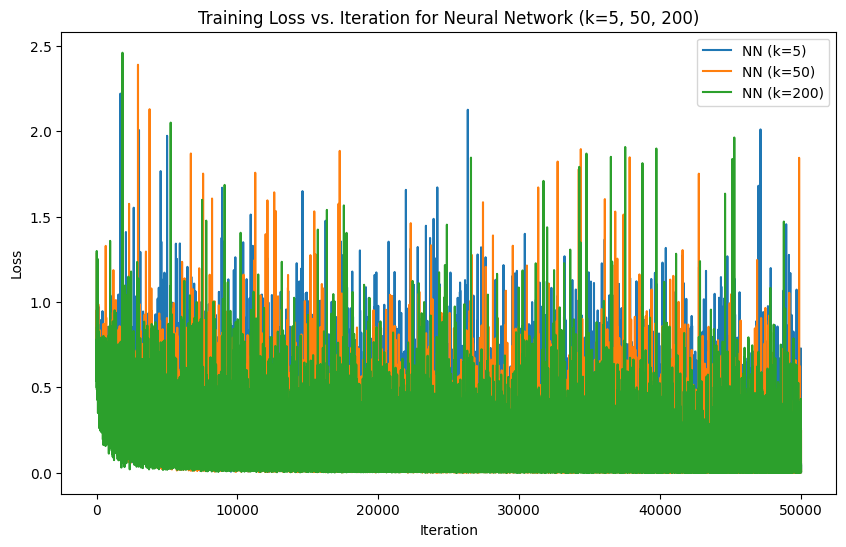

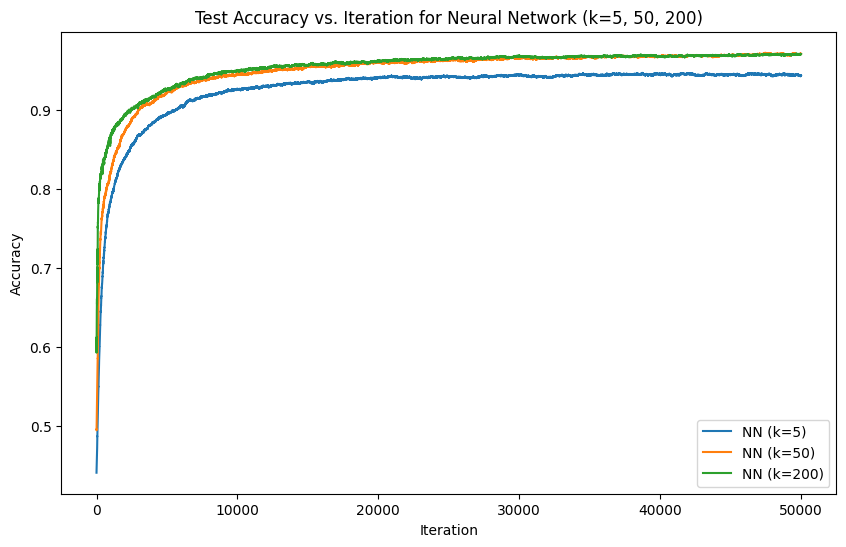

In [ ]:
lr_nn = 0.01
k_values = [5, 50, 200]
results = {}
B = 10
ITR = 50000

plt.figure(figsize=(10, 6))
plt.title("Training Loss vs. Iteration for Neural Network (k=5, 50, 200)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
loss_fig = plt.gca()

plt.figure(figsize=(10, 6))
plt.title("Test Accuracy vs. Iteration for Neural Network (k=5, 50, 200)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
acc_fig = plt.gca()

for k in k_values:
  print(f"Training Neural Network with k={k} hidden units, B={B}, ITR={ITR}, lr={lr_nn}")
  W1_nn, W2_nn, losses_nn, accs_nn, dur_nn = minibatch_sgd_nn_logistic(ITR, B, lr_nn, X_train, y_train, X_test, y_test, k)
  results[k] = {'losses': losses_nn, 'accs': accs_nn, 'dur': dur_nn}
  print(f"NN (k={k}, lr={lr_nn}): Time={dur_nn:.2f}s, Final Test Accuracy={accs_nn[-1]:.4f}")

  loss_fig.plot(losses_nn, label=f"NN (k={k})")
  acc_fig.plot(accs_nn, label=f"NN (k={k})")

loss_fig.legend()
acc_fig.legend()

plt.show()